<a href="https://colab.research.google.com/github/andizadry/Animals10-Image-Classification-MobileNet-TFLite/blob/main/Andi_Sadri_Agung_Image_Classification_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Submission Belajar Pengembangan Machine Learning**
##**Proyek Akhir : Image Classification Model Deployment**
Nama : Andi Sadri Agung

Domisili : Makassar, Sulawesi Selatan

Surel : andisadriagung20@gmail.com

Beasiswa : Lintasarta Cloudeka Digischool 2023 (Intermediate)

Dataset : https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [7]:
! pip install -q kaggle

In [8]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andisadriagung","key":"b1602937dea325c3a4e9c6fe0e33a205"}'}

In [9]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d alessiocorrado99/animals10

 98% 573M/586M [00:06<00:00, 241MB/s]
100% 586M/586M [00:06<00:00, 91.4MB/s]


In [70]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.applications import imagenet_utils
from keras import backend
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation

In [71]:
local_zip = '/content/animals10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [72]:
base_dir = '/content/raw-img'

Image shape for elefante: (270, 300)
Image shape for cane: (300, 272)
Image shape for pecora: (225, 300)
Image shape for scoiattolo: (225, 300)
Image shape for gatto: (200, 300)
Image shape for mucca: (188, 300)
Image shape for cavallo: (200, 300)
Image shape for gallina: (227, 300)
Image shape for ragno: (300, 300)
Image shape for farfalla: (199, 300)


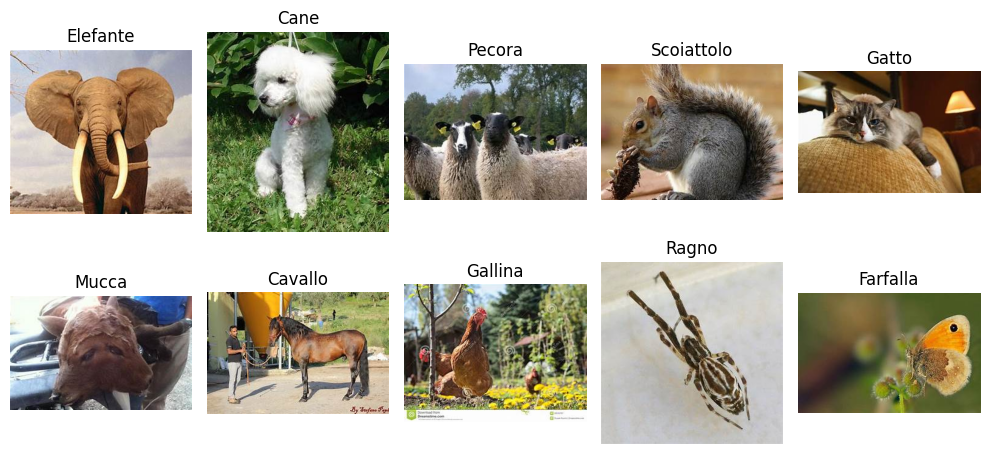

In [73]:
subdirectories = ['elefante', 'cane', 'pecora', 'scoiattolo', 'gatto', 'mucca', 'cavallo', 'gallina', 'ragno', 'farfalla']

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for i, subdirectory in enumerate(subdirectories):
    files = os.listdir(os.path.join(base_dir, subdirectory))
    image_path = os.path.join(base_dir, subdirectory, files[0])
    img = imread(image_path)
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(subdirectory.capitalize())
    print(f"Image shape for {subdirectory}: {img.shape[:2]}")

plt.tight_layout()
plt.show()

Count for elefante: 1446
Count for cane: 4863
Count for pecora: 1820
Count for scoiattolo: 1862
Count for gatto: 1668
Count for mucca: 1866
Count for cavallo: 2623
Count for gallina: 3098
Count for ragno: 4821
Count for farfalla: 2112


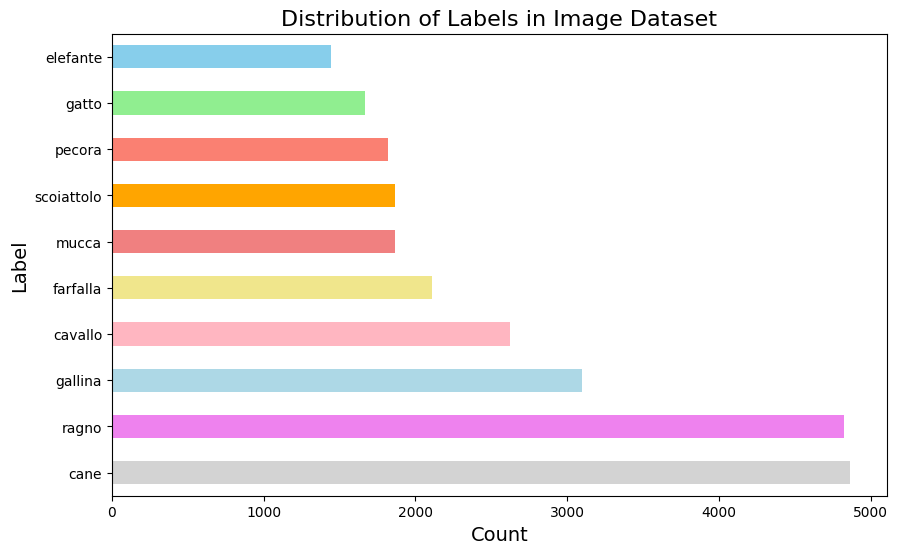

In [74]:
subdirectories = ['elefante', 'cane', 'pecora', 'scoiattolo', 'gatto', 'mucca', 'cavallo', 'gallina', 'ragno', 'farfalla']
counts = {}

total_images = 0

for subdirectory in subdirectories:
    files = os.listdir(os.path.join(base_dir, subdirectory))
    counts[subdirectory] = len(files)
    total_images += counts[subdirectory]
    print(f"Count for {subdirectory}: {counts[subdirectory]}")

df_counts = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'lightcoral', 'khaki', 'lightpink', 'lightblue', 'violet', 'lightgray']
df_counts.sort_values(by='Count', ascending=True).plot(kind='barh', x='Label', y='Count', ax=ax, color=colors, legend=False)


ax.set_title('Distribution of Labels in Image Dataset', fontsize=16)
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Label', fontsize=14)
ax.invert_yaxis()

plt.show()

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [76]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation = 'relu'),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          589888    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                      

In [77]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.95) and (logs.get('val_accuracy') > 0.93)):
      print("Accuracy has been achieved > 92%!")
      self.model.stop_training = True

checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

lr_reduction = ReduceLROnPlateau(
    monitor = 'accuracy',
    patience = 3,
    verbose = 1,
    factor = 0.1,
    min_lr = 0.000001
)

callbacks = myCallback()

In [78]:
train_steps = round(20948/128)
val_steps = round(5232/128)

hist = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = val_steps,
    verbose = 2,
    callbacks = [lr_reduction, callbacks, checkpoint]
)

Epoch 1/50

Epoch 1: accuracy improved from -inf to 0.79059, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 - 49s - loss: 0.6694 - accuracy: 0.7906 - val_loss: 0.8629 - val_accuracy: 0.8209 - lr: 0.0010 - 49s/epoch - 300ms/step
Epoch 2/50

Epoch 2: accuracy improved from 0.79059 to 0.85998, saving model to model_checkpoint.h5
164/164 - 44s - loss: 0.4474 - accuracy: 0.8600 - val_loss: 0.9649 - val_accuracy: 0.8034 - lr: 0.0010 - 44s/epoch - 265ms/step
Epoch 3/50

Epoch 3: accuracy improved from 0.85998 to 0.89367, saving model to model_checkpoint.h5
164/164 - 42s - loss: 0.3505 - accuracy: 0.8937 - val_loss: 0.4317 - val_accuracy: 0.8628 - lr: 0.0010 - 42s/epoch - 256ms/step
Epoch 4/50

Epoch 4: accuracy did not improve from 0.89367
164/164 - 55s - loss: 0.3692 - accuracy: 0.8842 - val_loss: 0.4139 - val_accuracy: 0.8742 - lr: 0.0010 - 55s/epoch - 338ms/step
Epoch 5/50

Epoch 5: accuracy improved from 0.89367 to 0.90320, saving model to model_checkpoint.h5
164/164 - 45s - loss: 0.3029 - accuracy: 0.9032 - val_loss: 0.4084 - val_accuracy: 0.8857 - lr: 0.0010 - 45s/epoch - 275ms/step
E

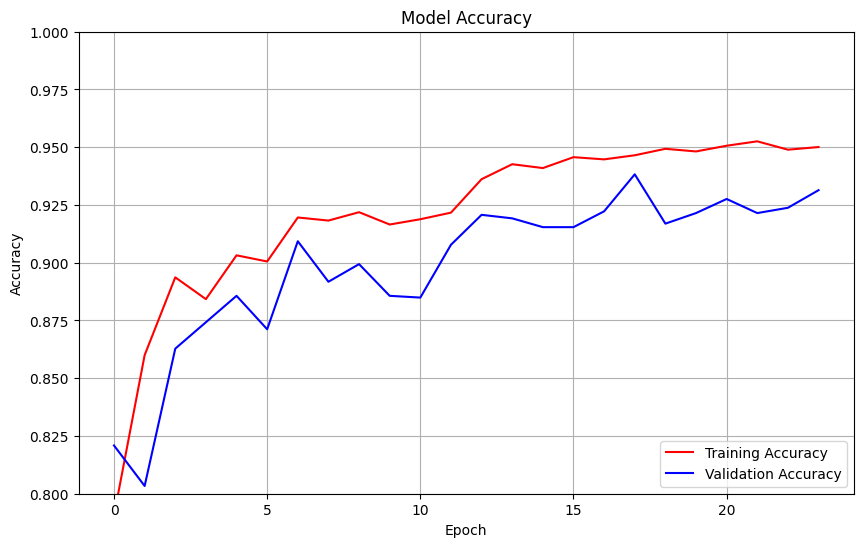

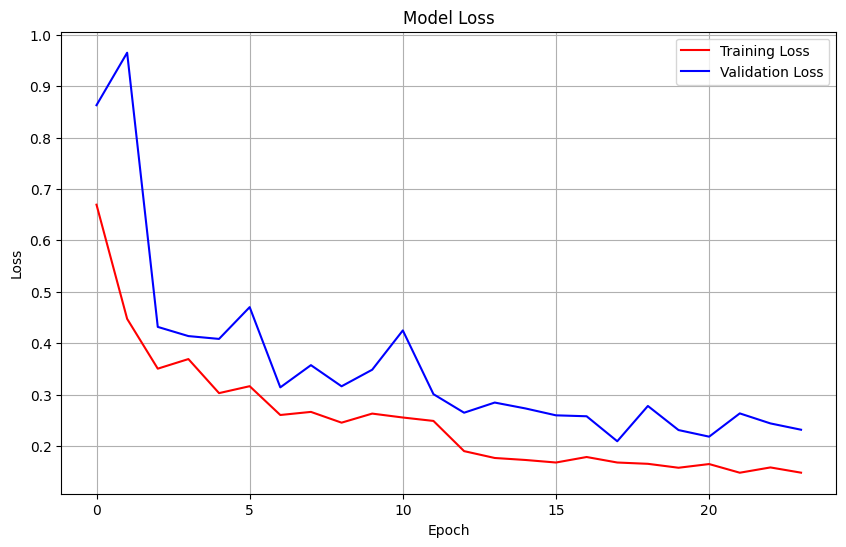

In [92]:
accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
validation_loss = hist.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(accuracy, 'r', label='Training Accuracy')
plt.plot(validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(loss, 'r', label='Training Loss')
plt.plot(validation_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [88]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [89]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [90]:
with tf.io.gfile.GFile('animas10_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)